
Beta-MSE (with intercept)
 LASSO       0.1044
RF          0.1082
CART        0.1095
CONSTANT    0.1326
GRU         0.1361
LSTM-GRU    0.1399
LSTM        0.1613
VAR         0.1716
dtype: float64

Macro-MSE (9 vars, excl. WTI)
 VAR         0.0194
GRU         0.0283
LSTM-GRU    0.0289
CONSTANT    0.0339
LASSO       0.0350
LSTM        0.0362
CART        0.0373
RF          0.0377
dtype: float64

>>> Best model by 9-variable Macro-MSE = VAR
>>> Other models (appendix) = ['GRU', 'LSTM-GRU', 'CONSTANT', 'LASSO', 'LSTM', 'CART', 'RF']


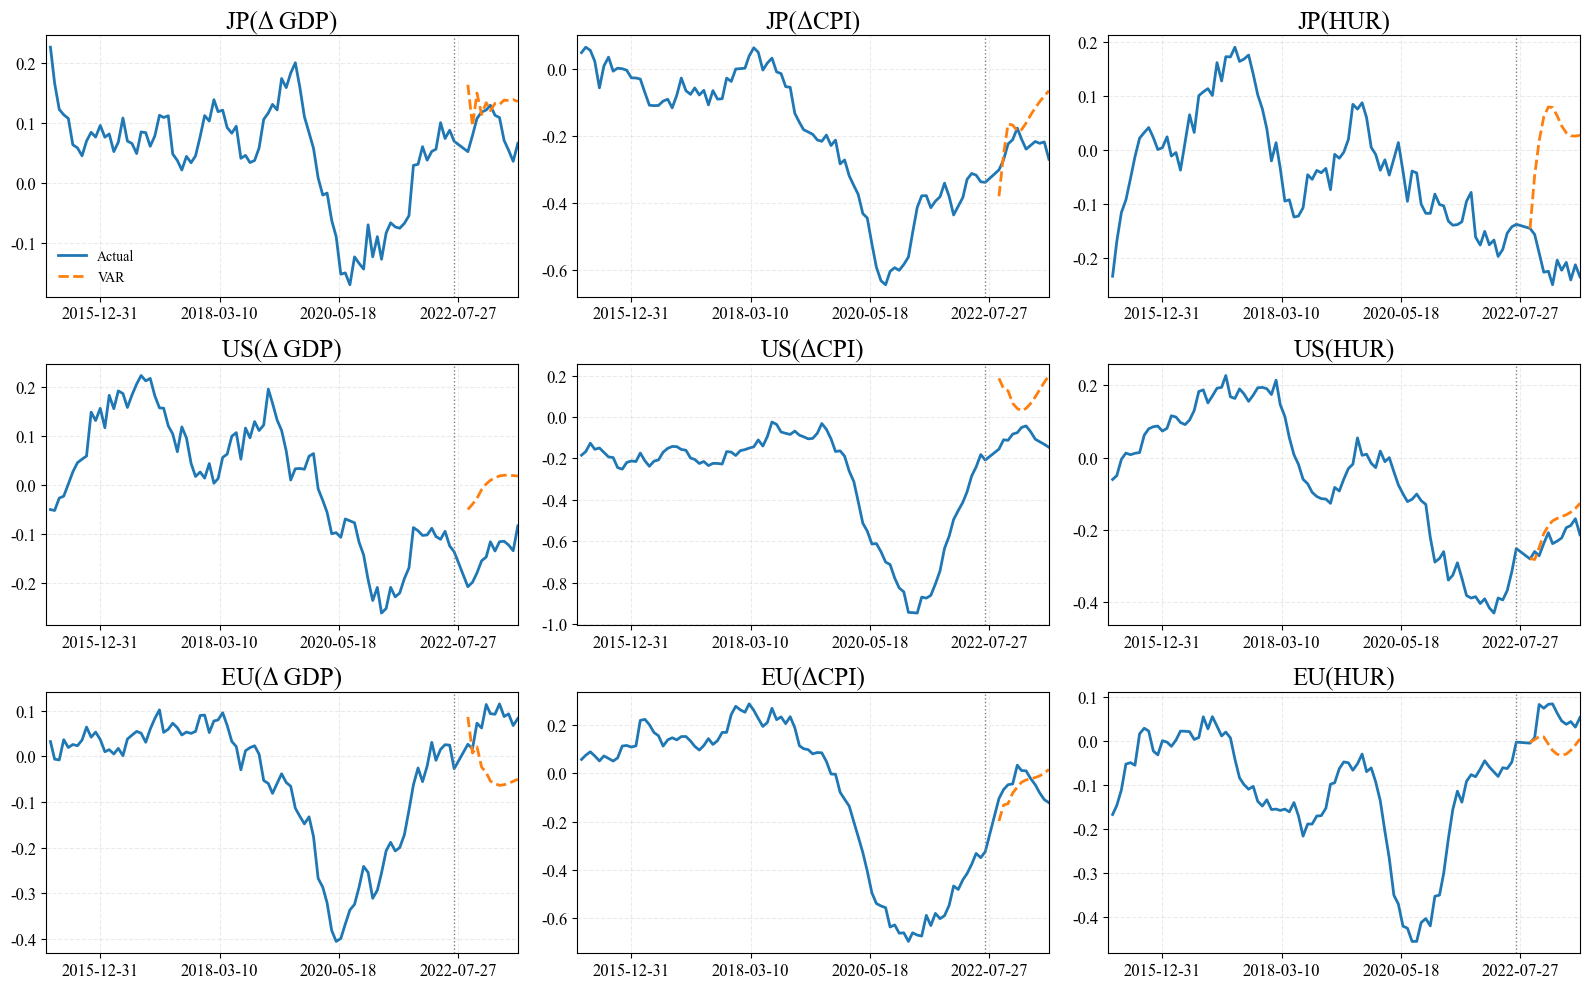

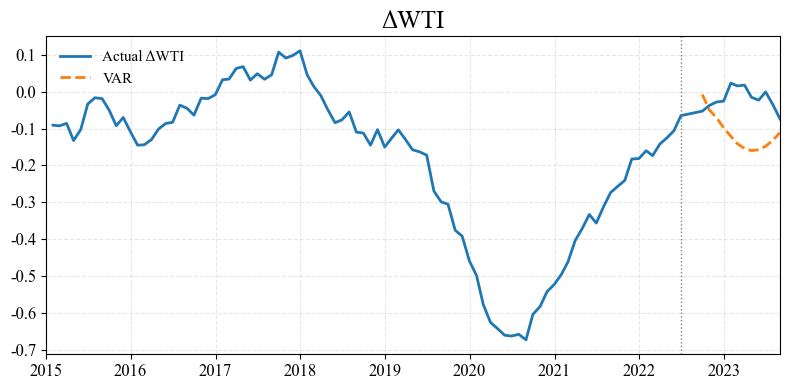


[Appendix] GRU


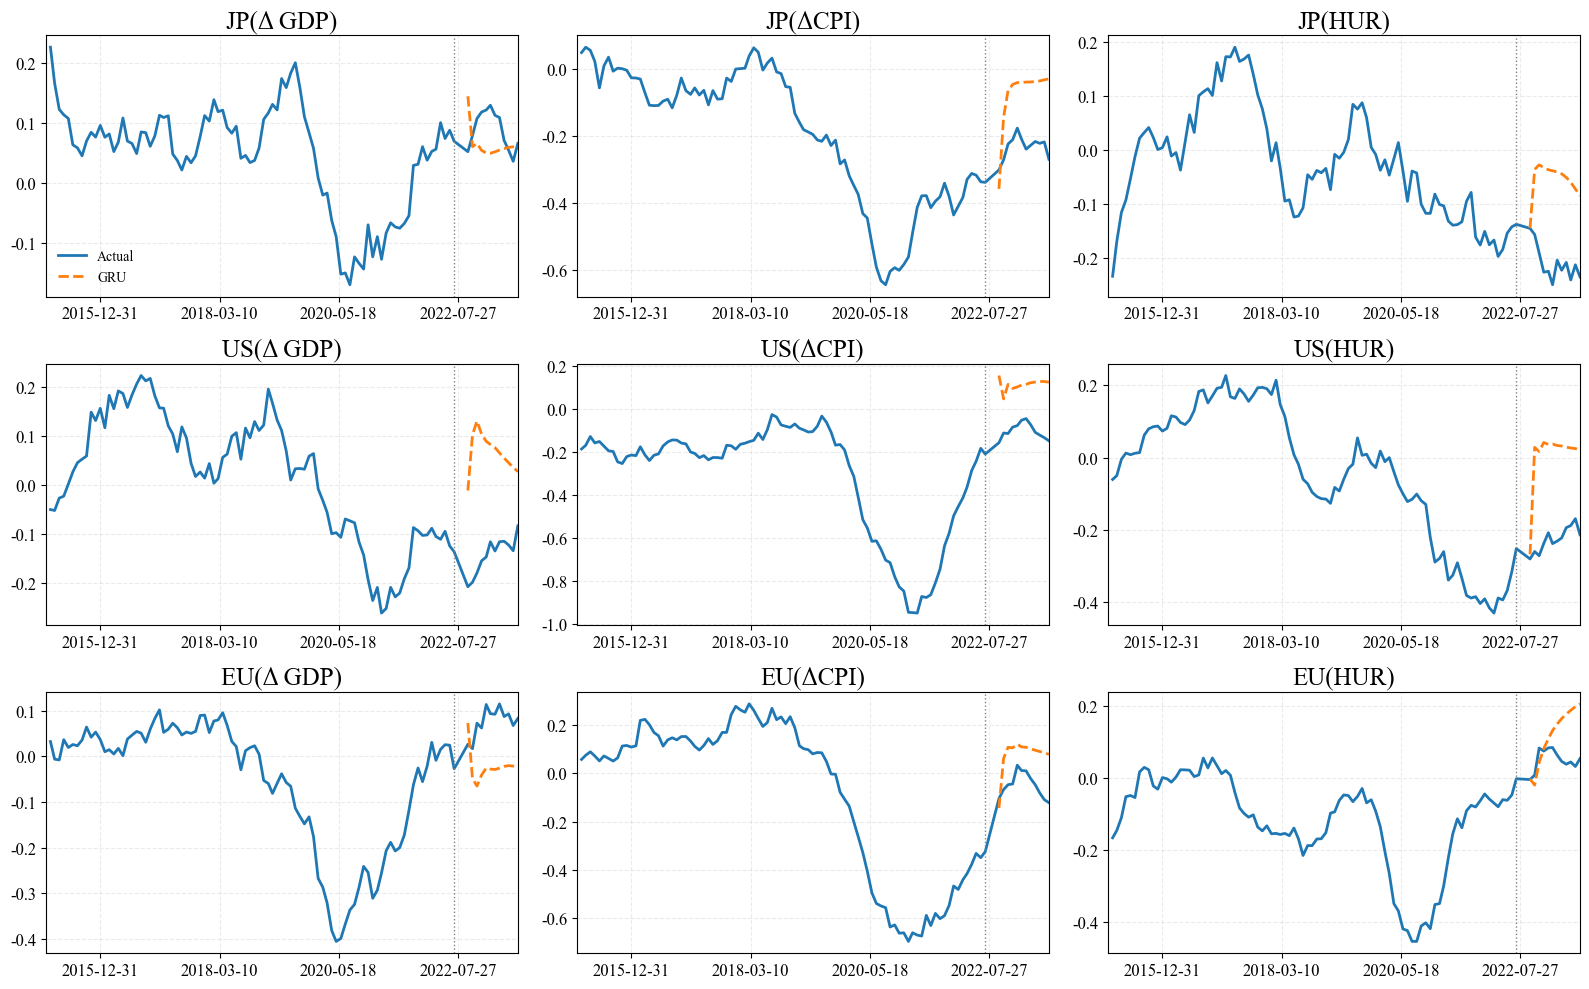


[Appendix] LSTM-GRU


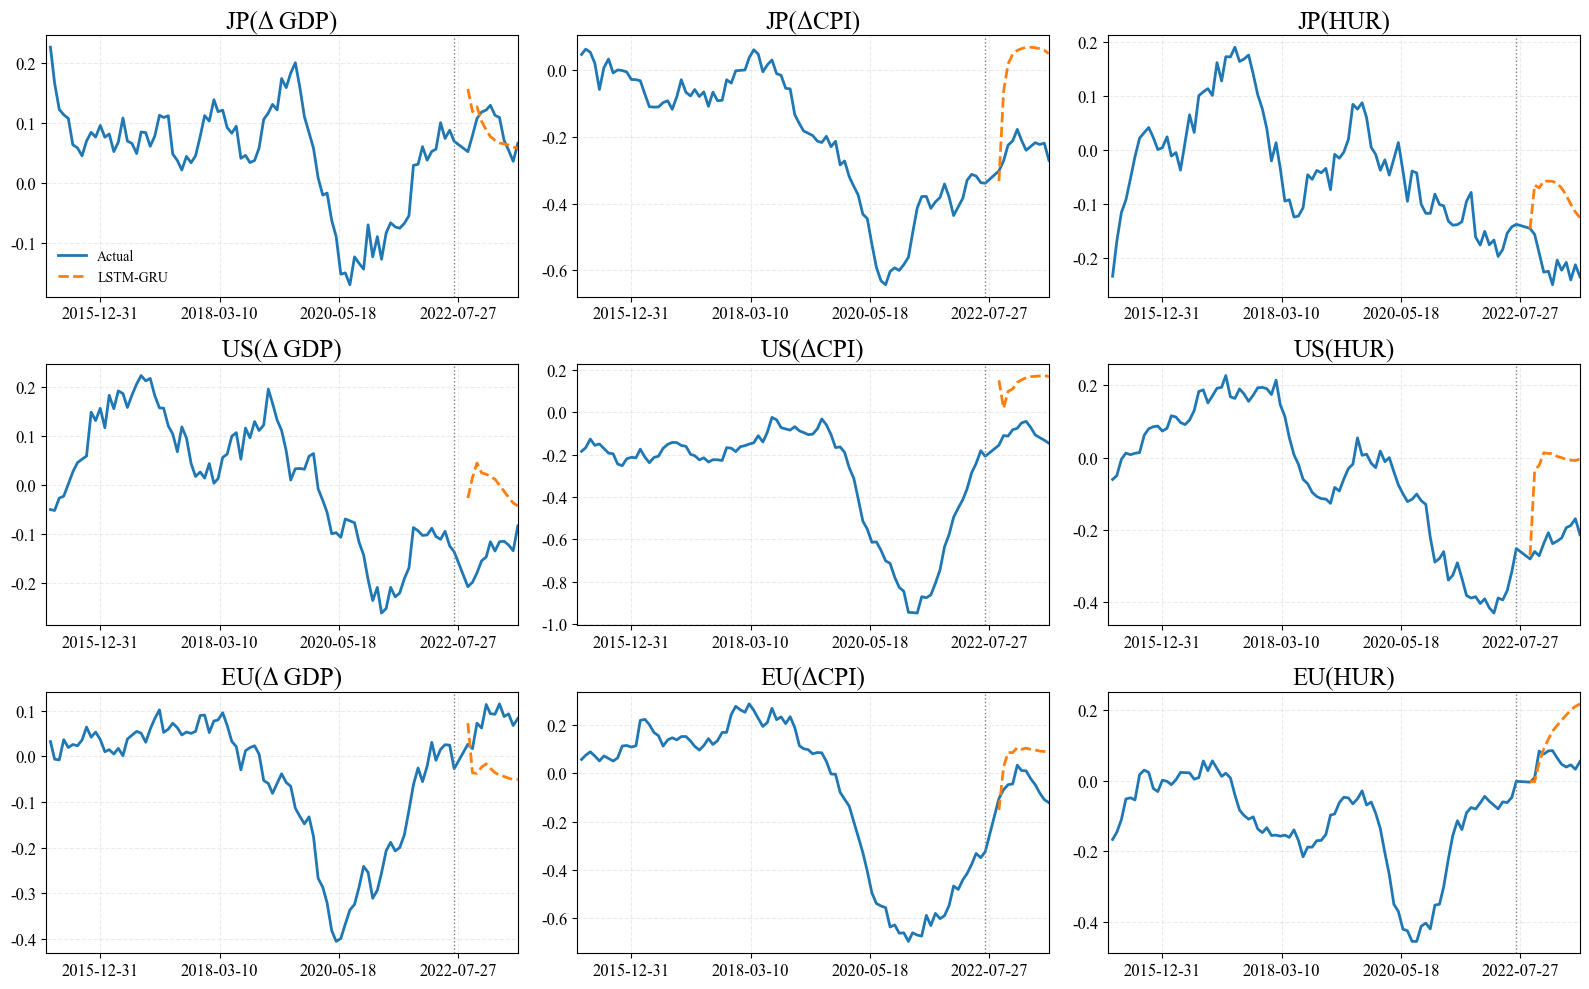


[Appendix] CONSTANT


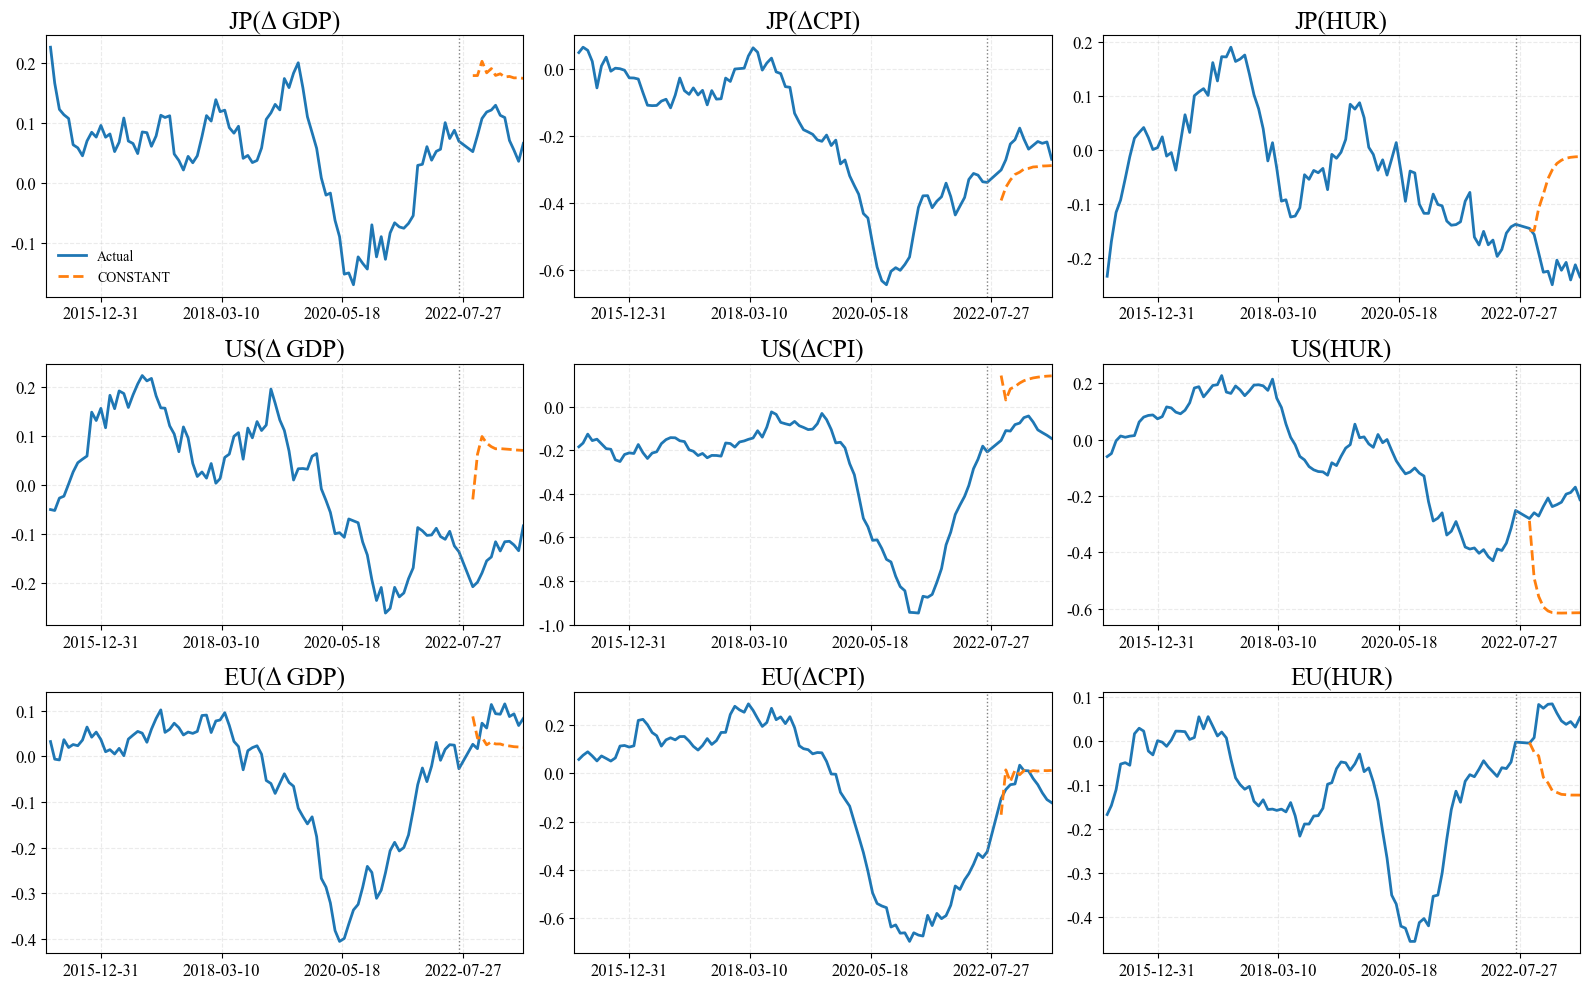


[Appendix] LASSO


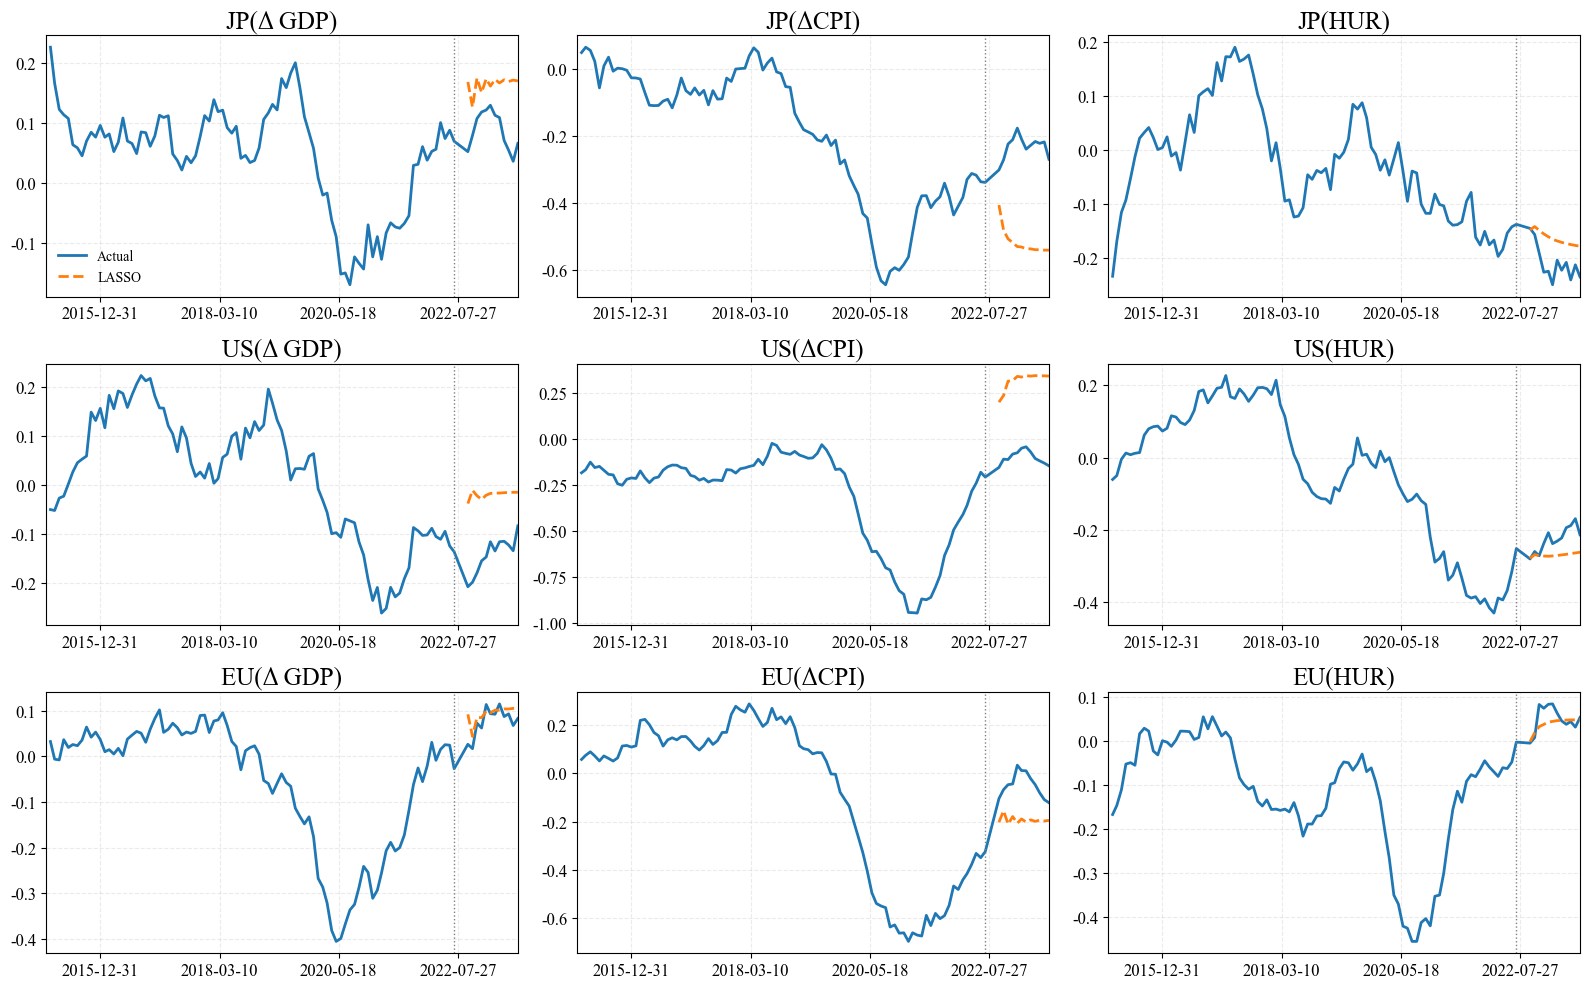


[Appendix] LSTM


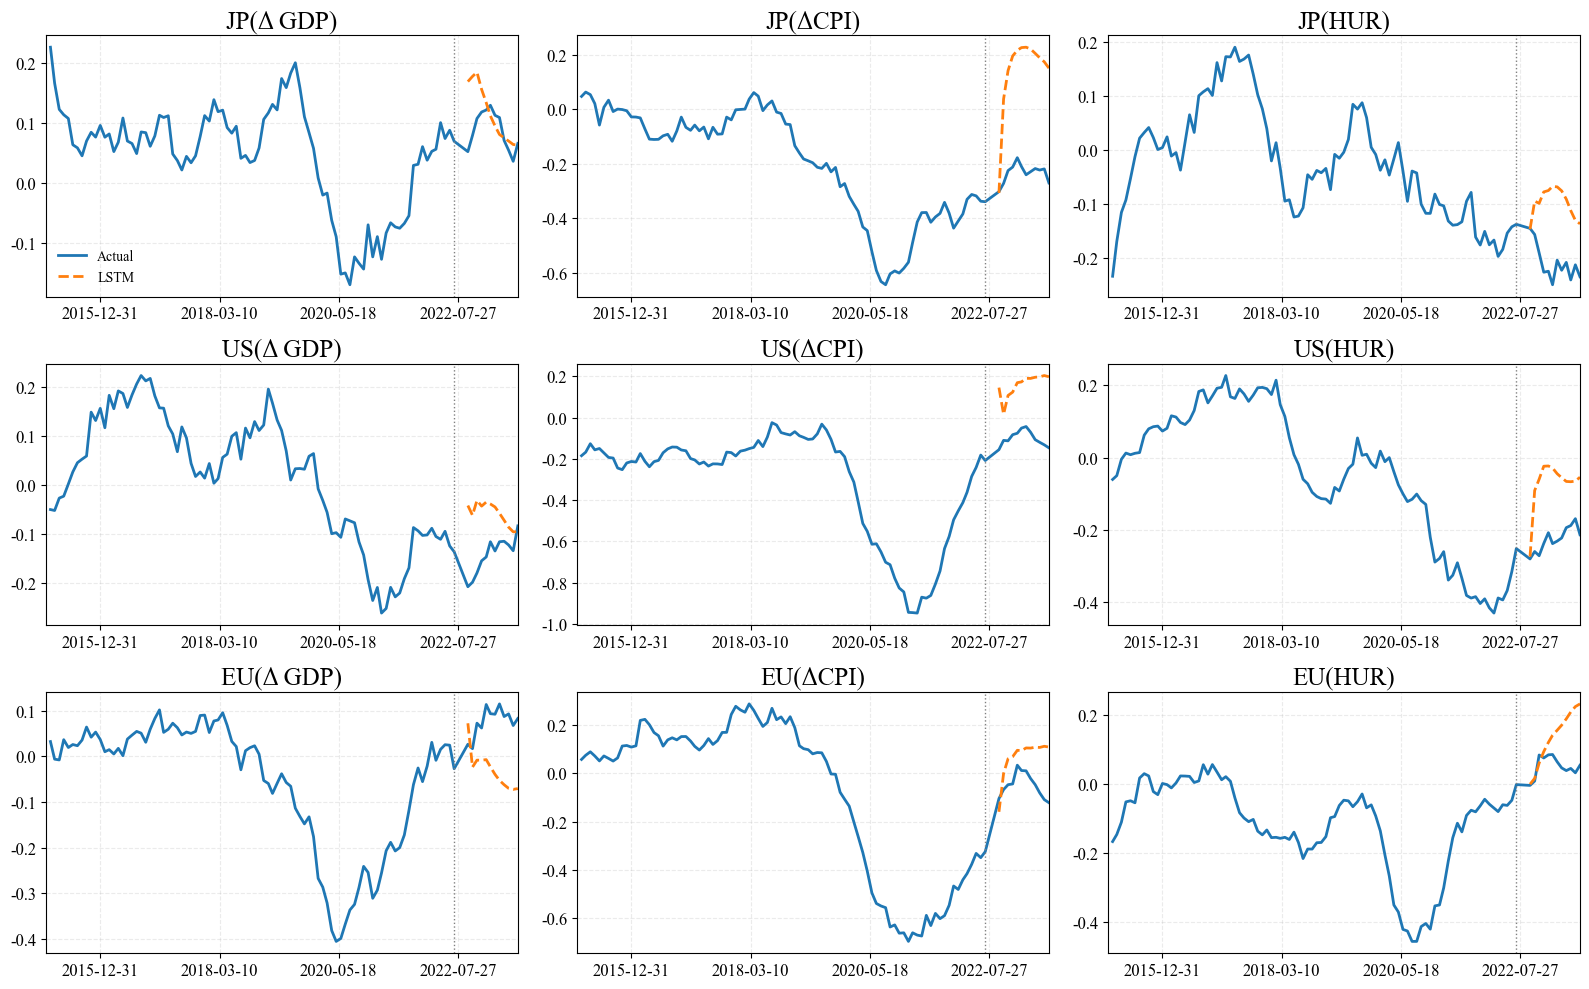


[Appendix] CART


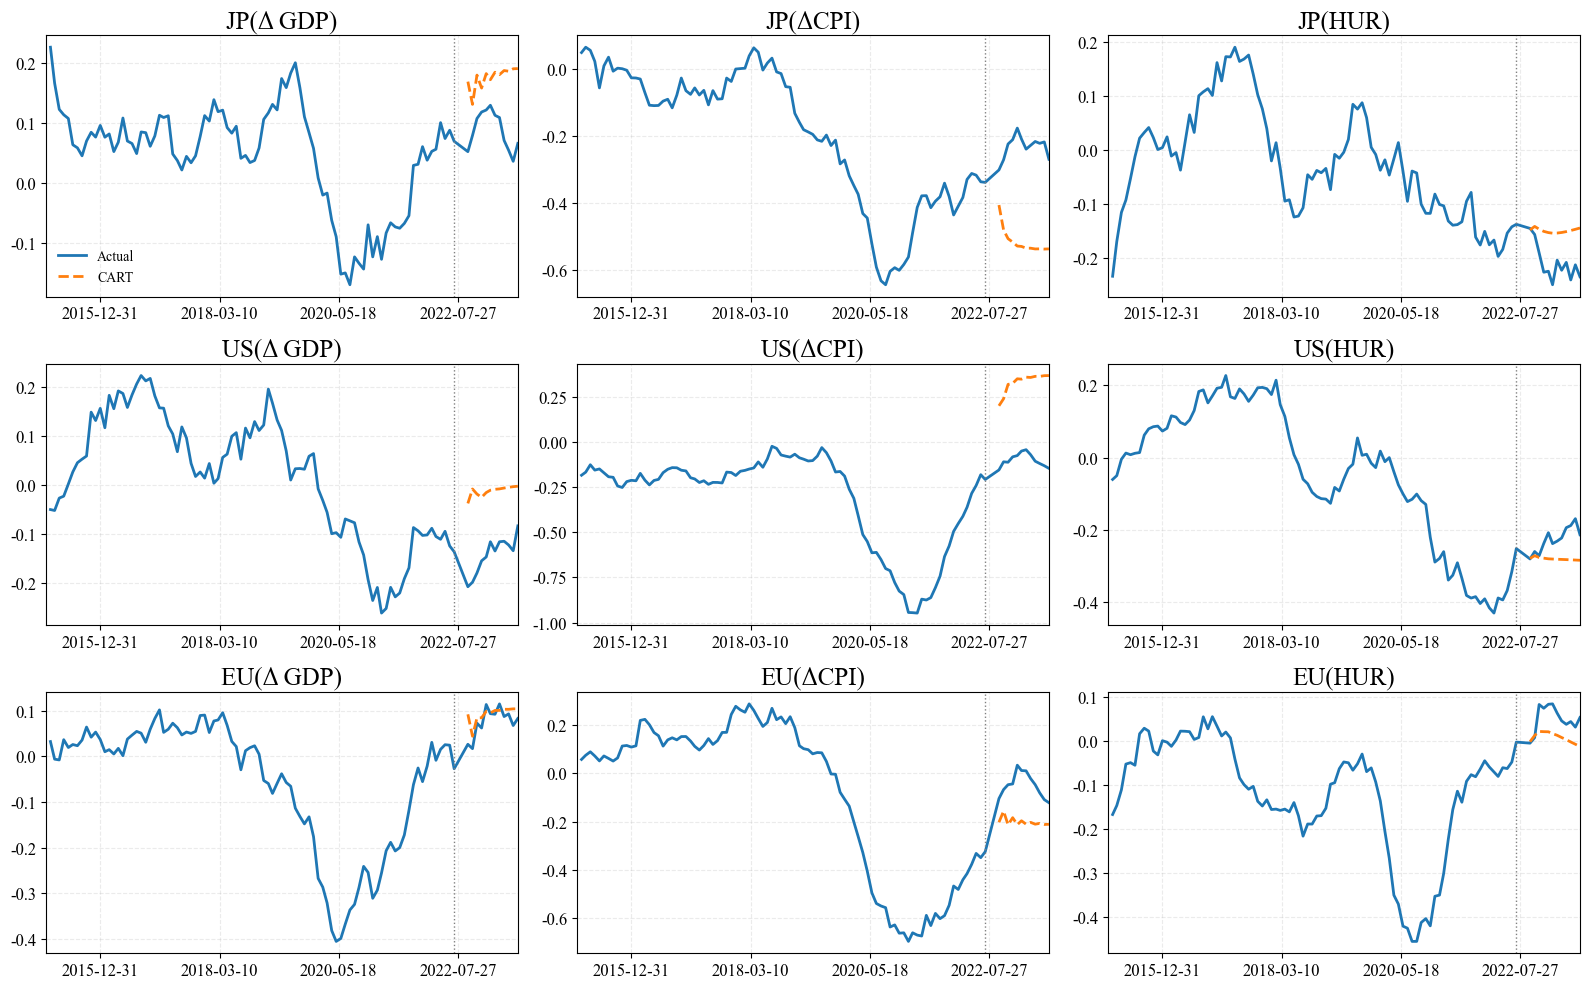


[Appendix] RF


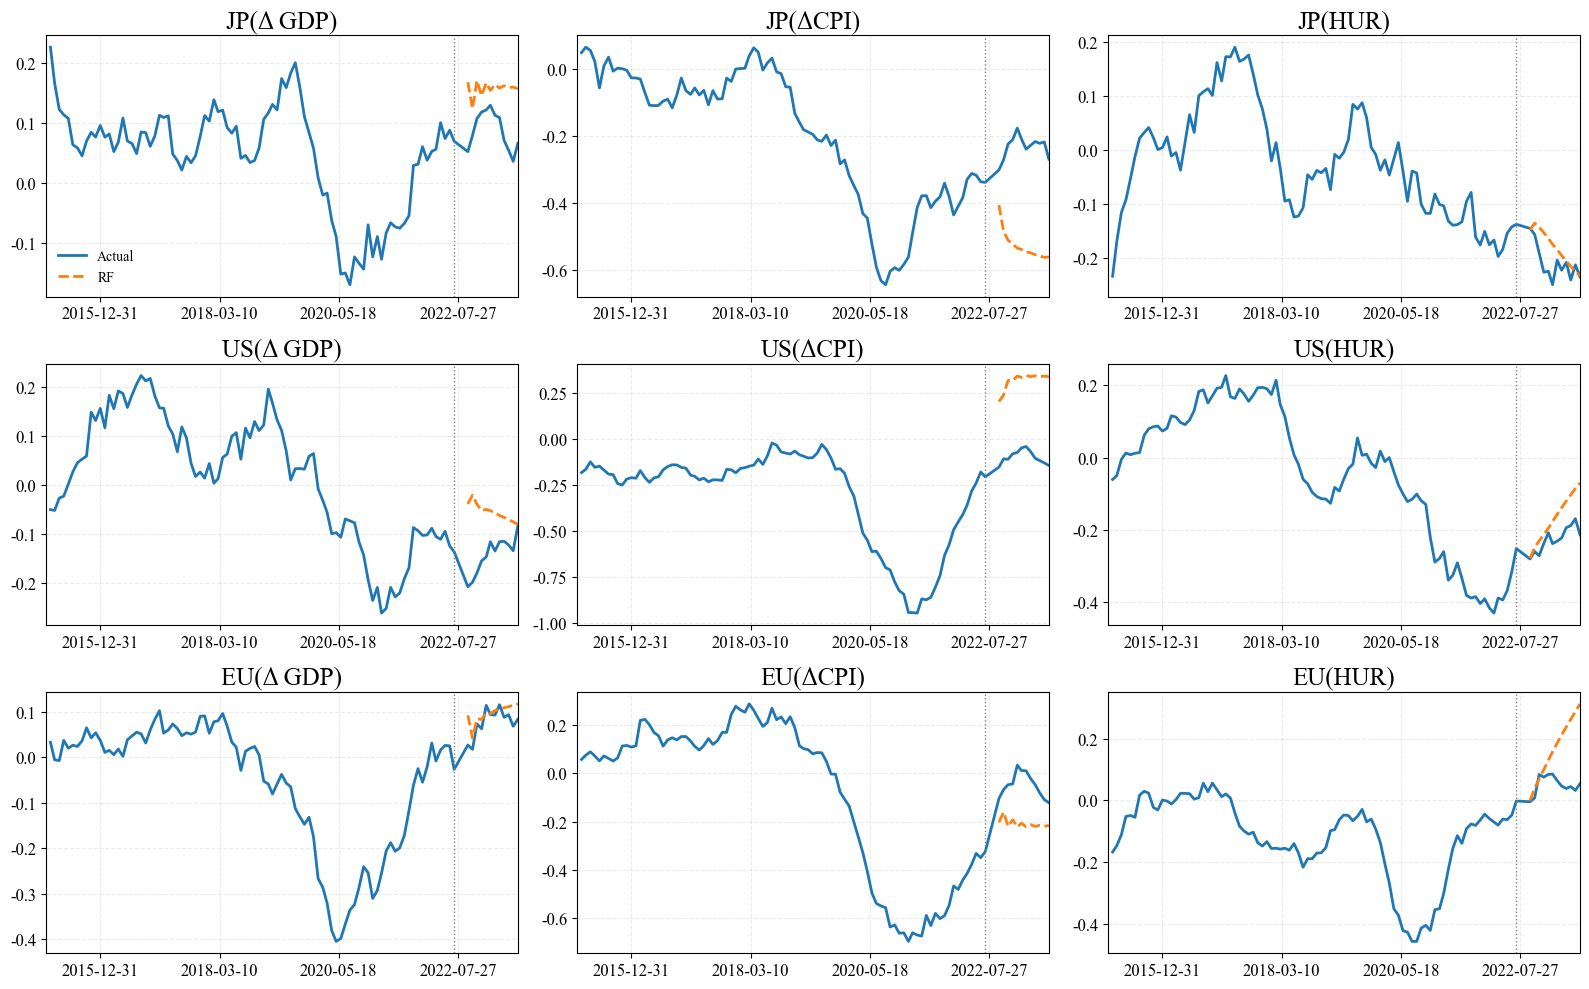


=== Scenario A: Macro-MSE(9 vars) Monte Carlo ===
       CONSTANT       VAR      CART        RF     LASSO      LSTM       GRU  \
count  100.0000  100.0000  100.0000  100.0000  100.0000  100.0000  100.0000   
mean     0.1525    0.1052    0.1585    0.1582    0.1570    0.1002    0.0958   
std      0.2643    0.2583    0.2667    0.2685    0.2674    0.2356    0.2470   
min      0.0342    0.0085    0.0412    0.0426    0.0411    0.0176    0.0117   
25%      0.0735    0.0368    0.0778    0.0785    0.0760    0.0347    0.0277   
50%      0.0973    0.0535    0.1025    0.1062    0.1011    0.0539    0.0521   
75%      0.1560    0.0881    0.1592    0.1553    0.1574    0.0841    0.0748   
max      2.6082    2.5279    2.6243    2.6506    2.6318    2.2844    2.4134   

       LSTM-GRU  
count  100.0000  
mean     0.0958  
std      0.2418  
min      0.0118  
25%      0.0294  
50%      0.0511  
75%      0.0727  
max      2.3540  


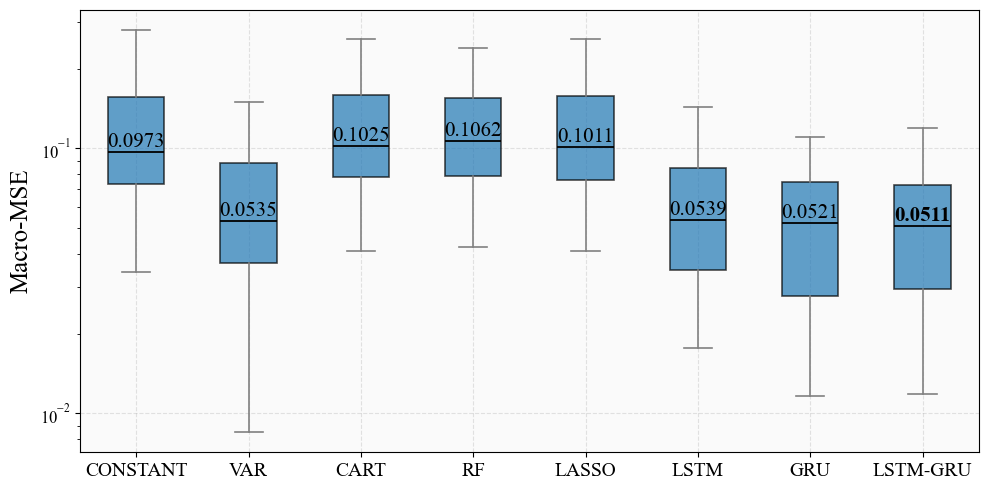

[Saved] C:\github\tvp-gvar-forecasting\figures\MacroMSE_Box_A.pdf


In [13]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import MultiTaskElasticNetCV, RidgeCV, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

plt.rcParams.update(
    {
        "font.family": "Times New Roman",
        "axes.unicode_minus": False,
        "axes.labelsize": 13,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "figure.titlesize": 15,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)

# === Trade weights ===
def make_trade_weights() -> np.ndarray:
    W = np.array(
        [
            [0.0, 0.13693266877823904, 0.15259712923860683],
            [0.44664201011502985, 0.0, 0.84740287076139320],
            [0.55335798988497020, 0.86306733122176090, 0.0],
        ],
        dtype=float,
    )
    np.fill_diagonal(W, 0.0)
    col = W.sum(axis=0, keepdims=True)
    col[col == 0] = 1.0
    return W / col

W_E = make_trade_weights()
COUNTRIES = ["JP", "US", "EU"]
COLIDX = {c: i for i, c in enumerate(COUNTRIES)}

def foreign_weighted_series(df: pd.DataFrame, importer: str, var_suffix: str) -> pd.Series:
    j = COLIDX[importer]
    out = 0.0
    for origin, i in COLIDX.items():
        w = W_E[i, j]
        if w == 0:
            continue
        out = out + w * df[f"{origin}_{var_suffix}"]
    return out

PRETTY_MAP = {
    "JP_GDP_D": "Japan ΔGDP",
    "US_GDP_D": "US ΔGDP",
    "EU_GDP_D": "EU ΔGDP",
    "JP_CPI_D": "Japan ΔCPI",
    "US_CPI_D": "US ΔCPI",
    "EU_CPI_D": "EU ΔCPI",
    "JP_HUR_D": "Japan ΔUnemp.",
    "US_HUR_D": "US ΔUnemp.",
    "EU_HUR_D": "EU ΔUnemp.",
    "WTI_D": "ΔWTI",
}

def pretty(var: str) -> str:
    return PRETTY_MAP.get(var, var.replace("_", " "))

# === Hyper-parameters ===
SPLIT_DATE = "2022-07-01"
P_LAG = 2
TEST_HORIZON = 12
ROLL_WIN = 20
LOOK_BACK = 10

USE_SIM = True
SIM_T = 360
SIM_START = "2001-01-01"
USE_DEEP = True

BATCH_SIZE = 64
MAX_EPOCH = 300
PATIENCE = 40
LSTM_DIMS = (128, 64)
GRU_DIMS = (128, 64)
DROPOUT_RATE = 0.3
REC_DROPOUT = 0.15
RIDGE_ALPHAS = np.logspace(-1, 2, 10)
RF_N_ESTIMATORS = 300
RF_MAX_DEPTH = 8
RF_MAX_FEATURES = "sqrt"
RF_MIN_SAMPLES_LEAF = 1
CART_MAX_DEPTH = 8
CART_MIN_SAMPLES_LEAF = 5
VAR_P = 1

FILE = "../data/macro_panel.xlsx"

def winsorize(df: pd.DataFrame, k: float = 2.5) -> pd.DataFrame:
    out = df.copy()
    for col in out.columns:
        s = out[col]
        mu, sd = s.mean(), s.std()
        out[col] = s.clip(mu - k * sd, mu + k * sd)
    return out

def load_data(path: str, P: int):
    cols = [
        "Date",
        "JP_GDP",
        "US_GDP",
        "EU_GDP",
        "JP_CPI",
        "US_CPI",
        "EU_CPI",
        "JP_HUR",
        "US_HUR",
        "EU_HUR",
        "WTI",
    ]
    df = (
        pd.read_excel(path, usecols=cols)
        .assign(Date=lambda x: pd.to_datetime(x["Date"]))
        .set_index("Date")
        .sort_index()
    )
    df = winsorize(df)

    df["WTI_D"] = df["WTI"].diff()
    df.drop(columns="WTI", inplace=True)

    for v in ("GDP", "CPI", "HUR"):
        for c in ("JP", "US", "EU"):
            df[f"{c}_{v}_D"] = df[f"{c}_{v}"].diff()
            df.drop(columns=f"{c}_{v}", inplace=True)

    df.dropna(inplace=True)

    for c in ("JP", "US", "EU"):
        for v in ("GDP_D", "CPI_D", "HUR_D"):
            df[f"{c}*FOR*{v}"] = foreign_weighted_series(df, importer=c, var_suffix=v)

    data = df.copy()
    for lag in range(1, P + 1):
        data = data.join(data.shift(lag).add_suffix(f"_lag{lag}"))
    data.dropna(inplace=True)

    split_ts = pd.Timestamp(SPLIT_DATE)
    tmp = data[data.index > split_ts].head(P_LAG + TEST_HORIZON)
    warm = tmp.iloc[:P_LAG]
    test = tmp.iloc[P_LAG:]
    train = data[data.index <= split_ts]

    return train, warm, test

# === Simulation branch ===
if USE_SIM:
    import sim_tvp_5gvar as sim

    T = SIM_T

    def months_between(a, b):
        return (b.year - a.year) * 12 + (b.month - a.month)

    START_TS = pd.Timestamp(SIM_START)
    SPLIT_TS = pd.Timestamp(SPLIT_DATE)
    BREAK_AT = months_between(START_TS, SPLIT_TS) + P_LAG
    BREAK_AT = max(P_LAG + 1, min(T - 2, BREAK_AT))

    SCENARIO_TAG = "A"  # "A"/"B"/"C"/"D"

    if SCENARIO_TAG == "A":
        params = dict(
            tvp=True,
            q_scale=0.015,
            eps_scale=0.020,
            hetero=False,
            break_at=BREAK_AT,
            trend_strength=0.0003,
            boost_mult=1.4,
            boost_block="FOREIGN",
        )
    elif SCENARIO_TAG == "B":
        params = dict(
            tvp=False,
            q_scale=0.0,
            eps_scale=0.070,
            hetero=True,
            break_at=BREAK_AT,
            trend_strength=0.0,
            boost_mult=1.0,
            boost_block=None,
        )
    elif SCENARIO_TAG == "C":
        params = dict(
            tvp=True,
            q_scale=0.020,
            eps_scale=0.055,
            hetero=True,
            break_at=int(0.35 * T),
            trend_strength=0.001,
            boost_mult=2.3,
            boost_block="FOREIGN",
        )
    elif SCENARIO_TAG == "D":
        params = dict(
            tvp=True,
            q_scale=0.001,
            eps_scale=0.020,
            hetero=True,
            break_at=BREAK_AT,
            trend_strength=0.0,
            boost_mult=2.0,
            boost_block="FOREIGN",
        )
    else:
        raise ValueError("Invalid scenario tag.")

    betas = sim.gen_beta_paths(
        T=T,
        P=P_LAG,
        tvp=params["tvp"],
        break_at=params["break_at"],
        q_scale=params["q_scale"],
        trend_strength=params["trend_strength"],
        boost_mult=params["boost_mult"],
        boost_block=params["boost_block"],
    )
    df_levels = sim.simulate_panel(
        T=T,
        P=P_LAG,
        betas=betas,
        start_date=SIM_START,
        hetero=params["hetero"],
        break_at=params["break_at"],
        eps_scale=params["eps_scale"],
    )

    spike_scenarios = {"B", "D"}
    if SCENARIO_TAG in spike_scenarios:
        spike_idx = min(params["break_at"], T - 3)
        spike_date = df_levels.index[spike_idx]
        next_date = df_levels.index[spike_idx + 1]

        shock_cols = [c for c in df_levels.columns if any(key in c for key in ["GDP", "CPI", "HUR"])]
        scale = 4.0
        jump = scale * df_levels[shock_cols].std()

        df_levels.loc[spike_date, shock_cols] += jump
        df_levels.loc[next_date, shock_cols] -= jump

        print(
            f"[Scenario {SCENARIO_TAG}] Spike at {spike_date.date()} "
            f"for {len(shock_cols)} series (scale={scale}x std)."
        )

    data = sim.add_foreign_and_lags(df_levels, P_LAG)

    split_ts = pd.Timestamp(SPLIT_DATE)
    tmp = data[data.index > split_ts].head(P_LAG + TEST_HORIZON)
    warm_df = tmp.iloc[:P_LAG]
    test_df = tmp.iloc[P_LAG:]
    train_df = data[data.index <= split_ts]

    assert len(test_df) == TEST_HORIZON
else:
    SCENARIO_TAG = "REAL DATA"
    train_df, warm_df, test_df = load_data(FILE, P_LAG)

H = len(test_df)
assert H == TEST_HORIZON

# === Saving ===
SAVE_DIR = "../results"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_pdf_if_real(fig, filename: str):
    if not USE_SIM:
        path = os.path.join(SAVE_DIR, filename)
        fig.savefig(path, format="pdf")
        print(f"[Saved] {path}")

eq_list = [f"{c}_{v}" for c in ("JP", "US", "EU") for v in ("GDP_D", "CPI_D", "HUR_D")] + ["WTI_D"]

reg_map: Dict[str, list] = {}
int_idx: list[int] = []
eq_size: Dict[str, int] = {}
cur = 0

for eq in eq_list:
    if eq == "WTI_D":
        feats = [f"WTI_D_lag{lag}" for lag in range(1, P_LAG + 1)]
    else:
        c, v = eq.split("_", 1)
        own = [f"{c}_{v}_lag{lag}" for lag in range(1, P_LAG + 1)]
        forw = [f"{c}*FOR*{v}_lag{lag}" for lag in range(1, P_LAG + 1)]
        wti = [f"WTI_D_lag{lag}" for lag in range(1, P_LAG + 1)]
        feats = own + forw + wti

    reg_map[eq] = feats
    k = 1 + len(feats)
    int_idx.append(cur)
    eq_size[eq] = k
    cur += k

PARAM_LEN = cur

# === Beta estimation ===
def beta_ols(df_blk: pd.DataFrame) -> np.ndarray:
    def fit1(X, y):
        try:
            return HuberRegressor().fit(X, y)
        except Exception:
            return RidgeCV(alphas=RIDGE_ALPHAS).fit(X, y)

    b = np.zeros(PARAM_LEN)
    for eq, idx in zip(eq_list, int_idx):
        X, y = df_blk[reg_map[eq]].values, df_blk[eq].values
        mdl = fit1(X, y)
        b[idx] = mdl.intercept_
        b[idx + 1 : idx + 1 + len(mdl.coef_)] = mdl.coef_
    return b

def kf_q0_auto(
    train_df: pd.DataFrame,
    roll_win: int = 20,
    floor: float = 5e-5,
    scale: float = 0.6,
) -> float:
    Bs = []
    for i in range(roll_win - 1, len(train_df)):
        blk = train_df.iloc[i - roll_win + 1 : i + 1]
        Bs.append(beta_ols(blk))
    B = np.vstack(Bs)
    dB = np.diff(B, axis=0)
    q0 = float(np.median(np.var(dB, axis=0))) * scale
    return max(q0, floor)

def beta_kf(
    df_blk: pd.DataFrame,
    q0: float = 2e-4,
    r_scale: float = 1.0,
) -> np.ndarray:
    b = np.zeros(PARAM_LEN)
    for eq, idx in zip(eq_list, int_idx):
        X = df_blk[reg_map[eq]].values
        y = df_blk[eq].values.reshape(-1, 1)
        n, p = X.shape
        m = p + 1

        beta = np.zeros((m, 1))
        P = 1e4 * np.eye(m)
        X1 = np.c_[np.ones(n), X]

        beta_ols_local = np.linalg.lstsq(X1, y, rcond=None)[0]
        y_hat_ols = X1 @ beta_ols_local
        r = float(np.var(y - y_hat_ols, ddof=min(5, n - 1))) * r_scale + 1e-8

        q = q0 * np.ones(m)
        I = np.eye(m)

        for t in range(n):
            Ht = np.r_[ [1.0], X[t] ].reshape(1, -1)
            P = P + np.diag(q)
            S = Ht @ P @ Ht.T + r
            K = (P @ Ht.T) / float(S)
            e = y[t : t + 1] - Ht @ beta
            beta = beta + K * e
            P = (I - K @ Ht) @ P

        b[idx : idx + m] = beta.flatten()

    return b

KF_Q0 = kf_q0_auto(train_df, roll_win=ROLL_WIN, floor=5e-5, scale=0.6)
block_beta = lambda df_blk: beta_kf(df_blk, q0=KF_Q0, r_scale=1.0)

beta_series = np.vstack(
    [block_beta(train_df.iloc[i - ROLL_WIN + 1 : i + 1]) for i in range(ROLL_WIN - 1, len(train_df))]
)
beta_static = block_beta(train_df)

# === Residual scale (EWMA) ===
sigma = {eq: 0.0 for eq in eq_list}
lam = 0.95

for eq, idx in zip(eq_list, int_idx):
    X = train_df[reg_map[eq]]
    y = train_df[eq]
    beta_vec = beta_static[idx : idx + eq_size[eq]]
    eps = y - (beta_vec[0] + X.values.dot(beta_vec[1:]))
    s = 0.0
    for e in eps:
        s = lam * s + (1 - lam) * abs(e)
    sigma[eq] = max(s, 1e-6)

# === Deep model data (beta paths) ===
scaler_beta = StandardScaler().fit(beta_series)
beta_scaled = scaler_beta.transform(beta_series)

N_PCA = beta_scaled.shape[1]
pca = PCA(n_components=N_PCA)
beta_low = pca.fit_transform(beta_scaled)

X_dl, y_dl = [], []
for i in range(len(beta_low) - LOOK_BACK):
    X_dl.append(beta_low[i : i + LOOK_BACK])
    y_dl.append(beta_low[i + LOOK_BACK])

X_dl = np.array(X_dl)
y_dl = np.array(y_dl)

# === Beta forecasters (8 models) ===
beta_hat: Dict[str, np.ndarray] = {}

beta_hat["CONSTANT"] = np.tile(beta_series[-ROLL_WIN:].mean(0), (H, 1))
beta_hat["VAR"] = VAR(beta_series).fit(maxlags=VAR_P).forecast(beta_series[-VAR_P:], H)

def cart_fc_delta() -> np.ndarray:
    Y = beta_series[1:] - beta_series[:-1]
    X = beta_series[:-1]
    m = DecisionTreeRegressor(
        max_depth=CART_MAX_DEPTH,
        min_samples_leaf=CART_MIN_SAMPLES_LEAF,
        random_state=42,
    ).fit(X, Y)
    prev = beta_series[-1].copy()
    ps = []
    for _ in range(H):
        d = m.predict(prev[None, :])[0]
        prev = prev + d
        ps.append(prev.copy())
    return np.vstack(ps)

beta_hat["CART"] = cart_fc_delta()

def rf_fc_delta() -> np.ndarray:
    Y = beta_series[1:] - beta_series[:-1]
    X = beta_series[:-1]
    m = RandomForestRegressor(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        max_features=RF_MAX_FEATURES,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF,
        n_jobs=-1,
        random_state=42,
    ).fit(X, Y)
    prev = beta_series[-1].copy()
    ps = []
    for _ in range(H):
        d = m.predict(prev[None, :])[0]
        prev = prev + d
        ps.append(prev.copy())
    return np.vstack(ps)

beta_hat["RF"] = rf_fc_delta()

def lasso_fc_delta(
    beta_series: np.ndarray,
    alpha_grid=np.logspace(-4, 0, 30),
    decay: float = 0.985,
    l1_ratio: float = 1.0,
) -> np.ndarray:
    dB = np.diff(beta_series, axis=0)
    B = beta_series[:-1]
    Z = np.hstack([B, dB])
    Y = dB

    X_scaler = StandardScaler().fit(Z)
    Y_scaler = StandardScaler().fit(Y)
    Xs = X_scaler.transform(Z)
    Ys = Y_scaler.transform(Y)

    n = len(Xs)
    w = np.array([decay ** (n - 1 - i) for i in range(n)])
    sw = np.sqrt(w)[:, None]
    Xsw = Xs * sw
    Ysw = Ys * sw

    tscv = TimeSeriesSplit(n_splits=5)
    lass = MultiTaskElasticNetCV(
        l1_ratio=l1_ratio,
        alphas=alpha_grid,
        cv=tscv,
        fit_intercept=True,
        n_jobs=-1,
        random_state=42,
    )
    lass.fit(Xsw, Ysw)

    support = np.any(lass.coef_ != 0, axis=0)

    if support.sum() >= 1:
        Xs_sub = Xs[:, support]
        Xsw_sub = Xs_sub * sw
        ridge = RidgeCV(alphas=RIDGE_ALPHAS).fit(Xsw_sub, Ysw)
        full_coef = np.zeros((PARAM_LEN, Xs.shape[1]))
        full_coef[:, support] = ridge.coef_
        ridge_intercept = ridge.intercept_

        def step(prev_beta, prev_dB):
            z = np.hstack([prev_beta, prev_dB]).reshape(1, -1)
            z_s = X_scaler.transform(z)
            dB_s = z_s @ full_coef.T + ridge_intercept
            dB_hat = Y_scaler.inverse_transform(dB_s).ravel()
            return dB_hat

    else:

        def step(prev_beta, prev_dB):
            return np.zeros_like(prev_beta)

    prev = beta_series[-1].copy()
    prev_d = np.zeros_like(prev)
    out = []
    for _ in range(H):
        d = step(prev, prev_d)
        prev = prev + d
        prev_d = d
        out.append(prev.copy())
    return np.vstack(out)

beta_hat["LASSO"] = lasso_fc_delta(beta_series)

def rnn_fc(cell, dims: tuple) -> np.ndarray:
    """RNN forecaster for beta_t."""
    tf.keras.backend.clear_session()

    inp = Input(shape=(LOOK_BACK, N_PCA))
    x = inp
    for h in dims:
        x = cell(
            h,
            dropout=DROPOUT_RATE,
            recurrent_dropout=REC_DROPOUT,
            return_sequences=True,
        )(x)
    x = cell(
        dims[-1] // 2,
        dropout=DROPOUT_RATE,
        recurrent_dropout=REC_DROPOUT,
    )(x)

    x = LayerNormalization()(x)
    x = Dropout(DROPOUT_RATE)(x)
    out = Dense(N_PCA)(x)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")

    ck = ModelCheckpoint(
        "best_tmp.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        verbose=0,
    )
    es = EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True,
    )

    model.fit(
        X_dl,
        y_dl,
        epochs=MAX_EPOCH,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        verbose=0,
        callbacks=[ck, es],
    )

    seq_low = beta_low[-LOOK_BACK:]
    preds_low = []

    for _ in range(H):
        nxt_low = model.predict(seq_low[None, :, :], verbose=0).squeeze()
        preds_low.append(nxt_low.copy())
        seq_low = np.vstack([seq_low[1:], nxt_low])

    preds_low = np.vstack(preds_low)
    beta_scaled_hat = pca.inverse_transform(preds_low)
    beta_hat_full = scaler_beta.inverse_transform(beta_scaled_hat)

    return beta_hat_full

USE_DEEP = USE_DEEP and (len(beta_scaled) >= 50)

if USE_DEEP:
    lstm_pred = rnn_fc(LSTM, LSTM_DIMS)
    gru_pred = rnn_fc(GRU, GRU_DIMS)
    beta_hat["LSTM"] = lstm_pred
    beta_hat["GRU"] = gru_pred
    beta_hat["LSTM-GRU"] = 0.5 * lstm_pred + 0.5 * gru_pred

# === Soft caps for beta ===
def _soft_cap(vec: np.ndarray, lim: float) -> np.ndarray:
    return np.tanh(vec / max(lim, 1e-6)) * lim

def cap_beta(
    bt: np.ndarray,
    P: int = P_LAG,
    caps=(0.9, 0.45, 0.35),
    cap_scale: float = 1.0,
) -> np.ndarray:
    own_cap, frm_cap, wti_cap = caps
    own_cap *= cap_scale
    frm_cap *= cap_scale
    wti_cap *= cap_scale

    out = bt.copy()
    for eq, idx in zip(eq_list, int_idx):
        k = eq_size[eq] - 1
        coefs = out[idx + 1 : idx + 1 + k]
        if eq == "WTI_D":
            out[idx + 1 : idx + 1 + k] = _soft_cap(coefs, 0.9 / P)
        else:
            own = _soft_cap(coefs[:P], 0.9 / P)
            frm = _soft_cap(coefs[P : 2 * P], 0.4 / P)
            wti = _soft_cap(coefs[2 * P : 3 * P], 0.4 / P)
            out[idx + 1 : idx + 1 + k] = np.r_[own, frm, wti]
    return out

# === Out-of-sample beta paths ===
def beta_oos(train_df: pd.DataFrame, test_df: pd.DataFrame) -> np.ndarray:
    all_df = pd.concat([train_df, test_df])
    T_train = len(train_df)
    out = []
    for t in range(T_train, T_train + len(test_df)):
        blk = all_df.iloc[t - ROLL_WIN + 1 : t + 1]
        out.append(block_beta(blk))
    return np.vstack(out)

beta_true_oos = beta_oos(train_df, test_df)
keep_mask = np.ones(PARAM_LEN, dtype=bool)
for idx in int_idx:
    keep_mask[idx] = False

# === Macro forecast ===
hist0 = [warm_df.iloc[-i - 1].to_dict() for i in range(P_LAG)]

def foreign_state(importer: str, var_suffix: str, state_row: dict) -> float:
    j = COLIDX[importer]
    val = 0.0
    for origin, i in COLIDX.items():
        w = W_E[i, j]
        if w == 0:
            continue
        val += w * state_row[f"{origin}_{var_suffix}"]
    return val

def forecast_macro(
    beta_seq: np.ndarray,
    smooth_alpha: float = 0.05,
    add_noise: bool = False,
    first_step_beta_blend: bool = True,
    gamma: float = 0.2,
    cap_scale_t0: float = 0.5,
    anchor_first_step: bool = True,
    anchor_hur_lambda: float = 0.8,
) -> pd.DataFrame:

    hist = [h.copy() for h in hist0]
    preds = []
    beta_prev = beta_series[-1]

    for t in range(H):
        bt = beta_seq[t]

        if t == 0 and first_step_beta_blend:
            bt = beta_prev + gamma * (bt - beta_prev)
        elif smooth_alpha > 0:
            bt = (1 - smooth_alpha) * bt + smooth_alpha * beta_prev

        bt = cap_beta(bt, P=P_LAG, cap_scale=(cap_scale_t0 if t == 0 else 1.0))

        nxt = {}
        for eq, idx in zip(eq_list, int_idx):
            if eq == "WTI_D":
                x = np.array([hist[i - 1]["WTI_D"] for i in range(1, P_LAG + 1)])
            else:
                c, v = eq.split("_", 1)
                arr = []
                for i in range(1, P_LAG + 1):
                    arr += [
                        hist[i - 1][f"{c}_{v}"],
                        foreign_state(importer=c, var_suffix=v, state_row=hist[i - 1]),
                        hist[i - 1]["WTI_D"],
                    ]
                x = np.array(arr)

            val = bt[idx] + bt[idx + 1 : idx + 1 + len(x)].dot(x)

            if add_noise:
                val += 0.35 * np.random.normal(0, sigma[eq])

            if anchor_first_step and t == 0 and eq.endswith("HUR_D"):
                last_obs = hist[0][eq]
                lam_h = anchor_hur_lambda
                val = (1.0 - lam_h) * val + lam_h * last_obs

            nxt[eq] = val

        preds.append(nxt)
        hist.insert(0, nxt)
        hist = hist[:P_LAG]
        beta_prev = bt

    return pd.DataFrame(preds, index=test_df.index)[eq_list]

# === Evaluation & plots ===
macro_pred = {k: forecast_macro(v, smooth_alpha=0.05, add_noise=False) for k, v in beta_hat.items()}

eq_list_9 = [v for v in eq_list if v != "WTI_D"]

macro_mse = {
    k: mean_squared_error(test_df[eq_list], macro_pred[k][eq_list]) for k in macro_pred
}
macro_mse_9 = {
    k: mean_squared_error(test_df[eq_list_9], macro_pred[k][eq_list_9]) for k in macro_pred
}

beta_keys = list(beta_hat.keys())
beta_mse = {k: mean_squared_error(beta_true_oos, beta_hat[k]) for k in beta_keys}
beta_mse_no_intercept = {
    k: mean_squared_error(beta_true_oos[:, keep_mask], beta_hat[k][:, keep_mask])
    for k in beta_keys
}

print("\nBeta-MSE (with intercept)\n", pd.Series(beta_mse).sort_values().round(4))
print("\nMacro-MSE (9 vars, excl. WTI)\n", pd.Series(macro_mse_9).sort_values().round(4))

mse9_series = pd.Series(macro_mse_9).sort_values()
best9 = mse9_series.idxmin()
other_models = [m for m in mse9_series.index if m != best9]

print(f"\n>>> Best model by 9-variable Macro-MSE = {best9}")
print(f">>> Other models (appendix) = {other_models}")

START = pd.Timestamp("2015-01-01")
SPLIT_TS = pd.Timestamp(SPLIT_DATE)
ACT_COLOR = "#1f77b4"
FC_COLOR = "#ff7f0e"
LW_MAIN = 2.0
LW_FC = 2.0

def short_title(var_diff: str) -> str:
    if var_diff == "WTI_D":
        return "ΔWTI"
    country = var_diff.split("_", 1)[0]
    if var_diff.endswith("GDP_D"):
        return f"{country}(Δ GDP)"
    if var_diff.endswith("CPI_D"):
        return f"{country}(ΔCPI)"
    if var_diff.endswith("HUR_D"):
        return f"{country}(HUR)"
    return var_diff.replace("_", " ")

def plot_9vars_panel_for_model(model_name: str, save_pdf: bool = False):
    prd_model = macro_pred[model_name]
    fig, axs = plt.subplots(3, 3, figsize=(16, 10), sharex=False)

    for i, var in enumerate(eq_list_9):
        ax = axs[i // 3, i % 3]

        actual_all = pd.concat([train_df[var], test_df[var]]).loc[START:]
        pred_use = prd_model[var].loc[START:]

        ax.plot(
            actual_all.index,
            actual_all.values,
            color=ACT_COLOR,
            lw=LW_MAIN,
            label="Actual",
        )
        ax.plot(
            pred_use.index,
            pred_use.values,
            color=FC_COLOR,
            lw=LW_FC,
            ls="--",
            label=model_name,
        )

        ax.axvline(SPLIT_TS, ls=":", color="gray", lw=1.0)
        ax.set_xlim(START, test_df.index[-1])
        ax.set_title(short_title(var), fontsize=18)

        if i == 0:
            ax.legend(fontsize=10, frameon=False)
        else:
            ax.legend().remove()

        ax.grid(axis="both", linestyle="--", alpha=0.25)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

    plt.tight_layout()

    if save_pdf:
        save_pdf_if_real(fig, f"{model_name}_9vars.pdf")

    plt.show()

# --- Best model: 9 vars panel + WTI ---
plot_9vars_panel_for_model(best9, save_pdf=True)

fig_wti = plt.figure(figsize=(8, 4))
act_wti = pd.concat([train_df["WTI_D"], test_df["WTI_D"]]).loc[START:]
prd_wti = macro_pred[best9]["WTI_D"].loc[START:]

plt.plot(act_wti.index, act_wti.values, color=ACT_COLOR, lw=LW_MAIN, label="Actual ΔWTI")
plt.plot(prd_wti.index, prd_wti.values, color=FC_COLOR, lw=LW_FC, ls="--", label=best9)
plt.axvline(SPLIT_TS, ls=":", color="gray", lw=1.0)
plt.xlim(START, test_df.index[-1])
plt.legend(frameon=False)
plt.grid(ls="--", alpha=0.3)
plt.title("ΔWTI", fontsize=18)
plt.tight_layout()
save_pdf_if_real(fig_wti, f"{best9}_WTI.pdf")
plt.show()

# --- Other models (appendix) ---
for mdl in other_models:
    print(f"\n[Appendix] {mdl}")
    plot_9vars_panel_for_model(mdl, save_pdf=True)

# === Single-run wrapper for Monte Carlo ===
def forecast_once(
    train_df: pd.DataFrame,
    warm_df: pd.DataFrame,
    test_df: pd.DataFrame,
    scenario_tag: str = "REAL DATA",
    seed: int = 0,
):
    np.random.seed(seed)
    random.seed(seed)

    macro_pred_local = {k: forecast_macro(v, smooth_alpha=0.0, add_noise=False) for k, v in beta_hat.items()}
    eq_list_9_local = [v for v in eq_list if v != "WTI_D"]

    macro_mse_9_local = {
        k: mean_squared_error(test_df[eq_list_9_local], macro_pred_local[k][eq_list_9_local])
        for k in macro_pred_local
    }
    return macro_mse_9_local

# === Monte Carlo (simulation only) ===
if USE_SIM:
    from sim_tvp_5gvar import simulate_and_preprocess

    R = 100
    scenario_tag = "A"
    records = []

    for r in range(R):
        train_df_mc, test_df_mc, df_levels_mc = simulate_and_preprocess(
            T=SIM_T,
            P=P_LAG,
            split_date=SPLIT_DATE,
            tvp=params["tvp"],
            break_at=params["break_at"],
            hetero=params["hetero"],
            q_scale=params["q_scale"],
            eps_scale=params["eps_scale"],
            trend_strength=params["trend_strength"],
        )

        warm_df_mc = df_levels_mc[df_levels_mc.index > pd.Timestamp(SPLIT_DATE)].head(P_LAG)

        res = forecast_once(
            train_df_mc,
            warm_df_mc,
            test_df_mc,
            scenario_tag,
            seed=r,
        )
        res["rep"] = r
        records.append(res)

    df_res = pd.DataFrame(records).set_index("rep")
    print(f"\n=== Scenario {scenario_tag}: Macro-MSE(9 vars) Monte Carlo ===")
    print(df_res.describe().round(4))

    fig, ax = plt.subplots(figsize=(10, 5))

    preferred_order = ["CONSTANT", "VAR", "CART", "RF", "LASSO", "LSTM", "GRU", "LSTM-GRU"]
    models = [m for m in preferred_order if m in df_res.columns]
    df_res = df_res[models]
    data = [df_res[m] for m in models]

    box = ax.boxplot(
        data,
        showmeans=False,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor="#1f77b4", alpha=0.7, linewidth=1.2),
        whiskerprops=dict(color="gray", linewidth=1.2),
        capprops=dict(color="gray", linewidth=1.2),
        medianprops=dict(color="black", linewidth=1.3),
    )

    labels_pretty = [m.replace("-", "\n") if len(m) > 10 else m for m in models]
    ax.set_xticks(range(1, len(models) + 1))
    ax.set_xticklabels(labels_pretty, fontsize=14, ha="center", linespacing=1.1)
    ax.margins(x=0.05)

    all_medians = [float(np.median(vals)) for vals in data]
    best_median = min(all_medians)

    for i, med in enumerate(all_medians):
        median_line = box["medians"][i]
        y_med = median_line.get_ydata()[0]
        ax.text(
            i + 1,
            y_med,
            f"{med:.4f}",
            ha="center",
            va="bottom",
            fontsize=15,
            weight="bold" if med == best_median else "normal",
            color="black",
        )

    ax.set_yscale("log")
    ax.set_ylabel("Macro-MSE", fontsize=18)
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.set_facecolor("#fafafa")

    plt.subplots_adjust(bottom=0.18, top=0.9)
    plt.tight_layout()

    save_path = os.path.join(SAVE_DIR, f"MacroMSE_Box_{scenario_tag}.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"[Saved] {save_path}")